# 🧠 DCGAN on MNIST with TensorFlow/Keras

**Problem Statement:**

How can we train a generative model that learns the underlying distribution of MNIST handwritten digits and is capable of producing new, realistic-looking digits that were not part of the original dataset?

This notebook trains a **Deep Convolutional Generative Adversarial Network (DCGAN)** on the **MNIST** handwritten digits dataset using **TensorFlow/Keras**.

The notebook is structured into clearly marked sections:

1. **Exploratory Analysis (EA)** – inspect raw MNIST digits and pixel distributions.  
2. **Preprocessing** – normalize images, add channel dimension, build a `tf.data` pipeline.  
3. **Model Building** – define the **generator** and **discriminator** (DCGAN architecture), losses, and optimizers.  
4. **Training** – adversarial training loop with checkpointing so training does *not* restart every time.  
5. **Results & Analysis** – visualize generated digits, compare real vs generated, plot training curves, and explore the latent space.


## 0. Setup and Imports

In [1]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# For Jupyter
%matplotlib inline

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [2]:
# Reproducibility and global configuration
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BATCH_SIZE = 128
NOISE_DIM = 100
EPOCHS = 50  # you can reduce for quick tests

print("Seed set:", SEED)
print("Batch size:", BATCH_SIZE)
print("Noise dimension:", NOISE_DIM)
print("Planned epochs:", EPOCHS)

Seed set: 42
Batch size: 128
Noise dimension: 100
Planned epochs: 50


---
Setting a random seed (SEED = 42) so results are repeatable each time you run the notebook.
This helps ensure the model starts with the same random values when debugging or comparing runs.

Configures key training settings:

BATCH_SIZE = 128 → how many images are processed at once during training

NOISE_DIM = 100 → size of the random noise vector fed into the generator

EPOCHS = 50 → how many times the model will train on the entire dataset

Prints the settings so you can see what configuration your model is using.

---

## 1. Exploratory Analysis (EA)

In this section we:

- Load the **MNIST** training data. The data set was downloaded from the Kaggle website  
- Inspect shapes and value ranges.  
- Visualize a grid of real handwritten digits.  
- Plot a histogram of pixel intensities to understand the raw data distribution.


In [3]:
# Load MNIST (raw, 0–255 pixel values)
(X_train_raw, y_train_raw), (_, _) = tf.keras.datasets.mnist.load_data()

print("Raw training data shape:", X_train_raw.shape)
print("Raw labels shape:", y_train_raw.shape)
print("Raw dtype:", X_train_raw.dtype)
print("Min / Max pixel values:", X_train_raw.min(), X_train_raw.max())

Raw training data shape: (60000, 28, 28)
Raw labels shape: (60000,)
Raw dtype: uint8
Min / Max pixel values: 0 255


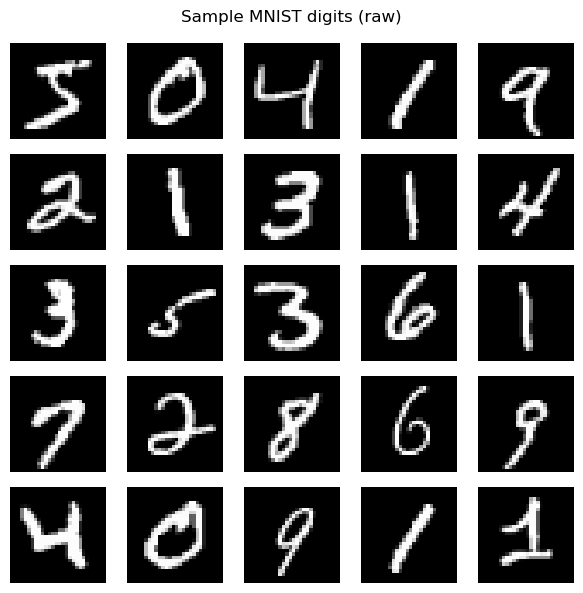

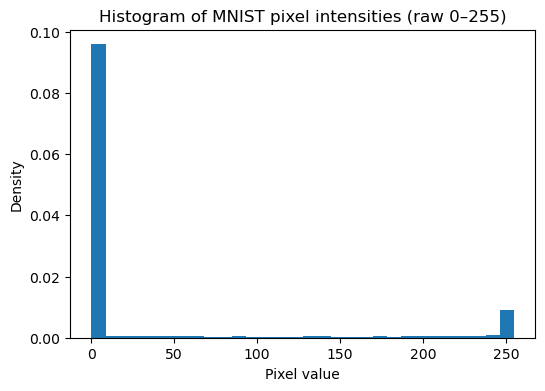

In [4]:
# Utility: show a grid of real digits
def show_real_digits(images, n=25, title="Sample MNIST digits (raw)"):
    n = min(n, images.shape[0])
    rows = cols = int(np.sqrt(n))
    plt.figure(figsize=(6, 6))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_real_digits(X_train_raw, n=25)

# Histogram of raw pixel intensities
plt.figure(figsize=(6, 4))
plt.hist(X_train_raw.flatten(), bins=30, density=True)
plt.title("Histogram of MNIST pixel intensities (raw 0–255)")
plt.xlabel("Pixel value")
plt.ylabel("Density")
plt.show()

---
Here you see a visualization of the raw data. The This histogram displays the distribution of raw pixel values in the MNIST dataset before any preprocessing. 
MNIST images are grayscale, and each pixel has a value from 0 to 255

---

## 2. Preprocessing

For GAN training we:

- Convert pixels from `uint8` to `float32`.  
- Normalize pixel values from **[0, 255] to [-1, 1]** (symmetric for `tanh` generator output).  
- Add a channel dimension to get shapes `(N, 28, 28, 1)`.  
- Build a shuffled, batched `tf.data.Dataset` pipeline for efficient training.


In [5]:
# Normalize to [-1, 1]
X_train = X_train_raw.astype("float32")
X_train = (X_train - 127.5) / 127.5  # [0,255] -> [-1,1]

# Add channel dimension: (N, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)

BUFFER_SIZE = X_train.shape[0]

train_dataset = (
    tf.data.Dataset.from_tensor_slices(X_train)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=False)  # allow last batch to be smaller
)

print("Preprocessed training data shape:", X_train.shape)
print("Buffer size:", BUFFER_SIZE, "| Batch size:", BATCH_SIZE)

Preprocessed training data shape: (60000, 28, 28, 1)
Buffer size: 60000 | Batch size: 128


---
This code cleans and formats the MNIST images so the GAN can learn properly:
- scale pixels
- add channel dimension
- shuffle + batch
It turns raw images into a training-ready dataset.

---

## 3. Model Building – DCGAN Architecture

We define two neural networks:

- **Generator**: takes a random noise vector \( z \in \mathbb{R}^{\text{NOISE\_DIM}} \) and outputs a `28×28×1` image.  
- **Discriminator**: takes an image and outputs a single logit indicating **real** vs **fake**.

This follows the **DCGAN** guidelines: Conv2DTranspose in the generator and Conv2D with strided downsampling in the discriminator.


### 3.1 Generator

In [6]:
def build_generator(noise_dim=NOISE_DIM):
    model = tf.keras.Sequential(
        [
            layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Reshape((7, 7, 256)),  # 7x7x256

            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),           # 7x7x128

            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),           # 14x14x64

            layers.Conv2DTranspose(
                1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
            ),                            # 28x28x1
        ],
        name="generator",
    )
    return model

generator = build_generator()
generator.summary()

C:\Users\masoc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

### 3.2 Discriminator

In [7]:
def build_discriminator():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dense(1),  # logits
        ],
        name="discriminator",
    )
    return model

discriminator = build_discriminator()
discriminator.summary()

C:\Users\masoc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### 3.3 Loss functions and optimizers

---
We are building two neural networks that make up a Deep Convolutional Generative Adversarial Network (DCGAN):

The Generator

The Discriminator

The DCGAN structure allows the two models to learn together:

 - Generator improves by producing images that fool the discriminator.

 - Discriminator improves by learning to detect subtle differences between real and fake images.

Both networks use:

 - Binary cross-entropy loss (on logits)

 - Adam optimizer (stable choice for GANs)

Generator Loss:

Tries to fool the discriminator → wants discriminator to output “real” for fake images.

Through this process, the generator eventually learns to produce highly realistic handwritten digits.
These two models compete during training, which helps the system learn how to create realistic handwritten digits.

---

In [8]:
# Binary cross-entropy on logits
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # We want the discriminator to think generated images are real (label=1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) / 2.0

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

print("Loss and optimizers set up.")

Loss and optimizers set up.


### 3.4 Checkpointing (avoid restarting training from scratch)

We use `tf.train.Checkpoint` and `CheckpointManager` to save and restore:

- Generator and discriminator weights  
- Optimizer states  
- Current epoch counter  

This lets us **resume training** where we left off instead of starting over every time we re-run the notebook.


In [9]:
# Directory for checkpoints
checkpoint_dir = "./dcgan_mnist_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Epoch counter stored in the checkpoint
epoch_counter = tf.Variable(0, dtype=tf.int64, trainable=False, name="epoch_counter")

ckpt = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    epoch_counter=epoch_counter,
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# Try to restore latest checkpoint if it exists
start_epoch = 1
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_epoch = int(epoch_counter.numpy()) + 1
    print(f"✅ Restored from {ckpt_manager.latest_checkpoint}, starting at epoch {start_epoch}.")
else:
    print("⌛ No checkpoint found, starting from scratch.")

⌛ No checkpoint found, starting from scratch.


## 4. Training the DCGAN

We define a custom training loop:

- Sample random noise and generate fake images with the **generator**.  
- Pass both real and fake images through the **discriminator**.  
- Compute generator and discriminator losses.  
- Update both networks via gradient descent.  
- Periodically:
  - Save generated samples  
  - Save checkpoints  
  - Track losses for later analysis  


### 4.1 Single training step

In [10]:
@tf.function
def train_step(images):
    # Handle variable batch size (last batch can be smaller)
    current_batch_size = tf.shape(images)[0]
    noise = tf.random.normal([current_batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

### 4.2 Visualization utility during training

In [11]:
def generate_and_save_images(model, epoch, test_input, save_dir="dcgan_images"):
    os.makedirs(save_dir, exist_ok=True)
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i, :, :, 0] + 1.0) / 2.0  # back to [0,1]
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Generated digits – Epoch {epoch}")
    plt.tight_layout()
    plt.show()

    filename = os.path.join(save_dir, f"epoch_{epoch:03d}.png")
    fig.savefig(filename)
    plt.close(fig)

### 4.3 Full training loop (with resume capability)

Set `TRAIN_MODEL = True` if you want to train.  
If it's `False`, the cell will **only restore the latest checkpoint** and *skip* training, so you can run analysis cells without retraining.


Starting (or resuming) training from epoch 1 to 50.
Epoch 001 | Gen Loss: 0.8543 | Disc Loss: 0.5524


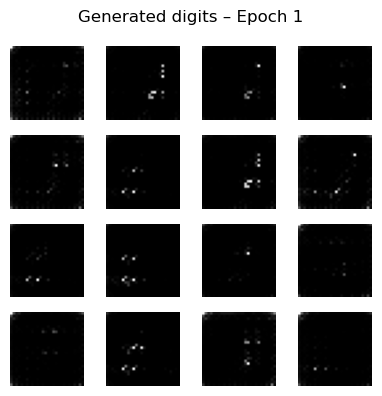

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-1
Epoch 005 | Gen Loss: 0.9295 | Disc Loss: 0.6050


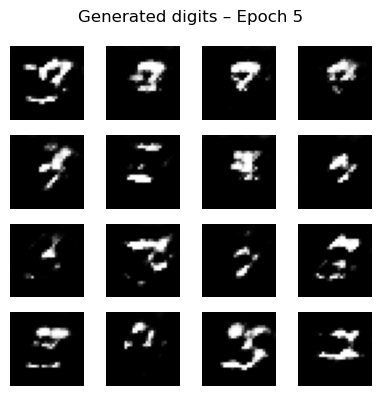

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-2
Epoch 010 | Gen Loss: 1.1139 | Disc Loss: 0.5443


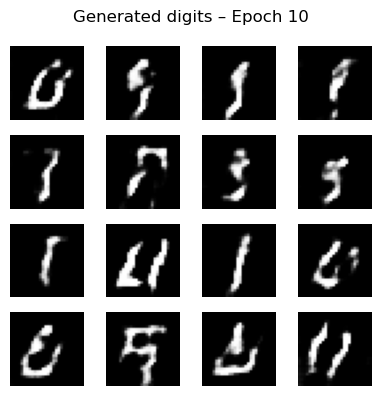

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-3
Epoch 015 | Gen Loss: 1.0136 | Disc Loss: 0.5932


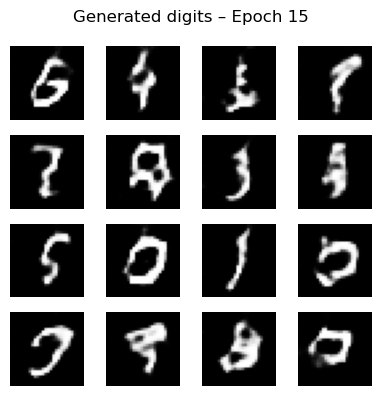

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-4
Epoch 020 | Gen Loss: 0.9581 | Disc Loss: 0.6129


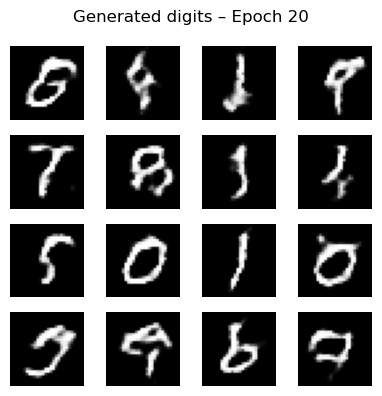

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-5
Epoch 025 | Gen Loss: 0.9145 | Disc Loss: 0.6262


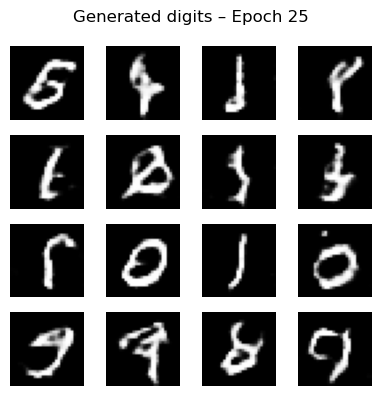

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-6
Epoch 030 | Gen Loss: 0.9068 | Disc Loss: 0.6241


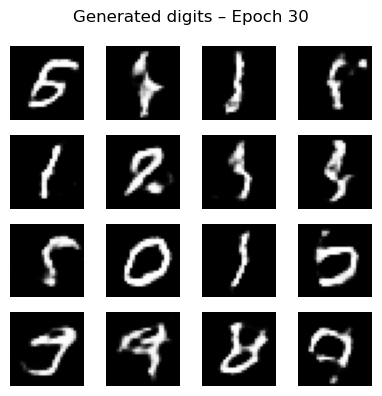

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-7
Epoch 035 | Gen Loss: 0.8978 | Disc Loss: 0.6256


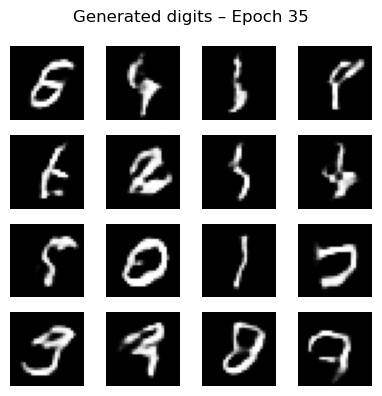

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-8
Epoch 040 | Gen Loss: 0.9369 | Disc Loss: 0.6223


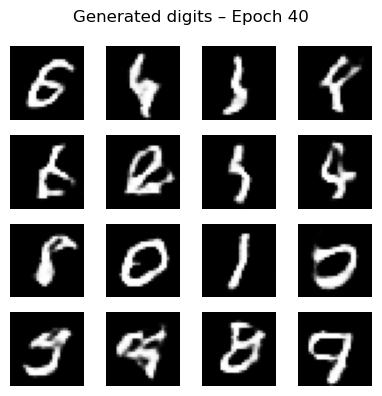

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-9
Epoch 045 | Gen Loss: 0.8779 | Disc Loss: 0.6328


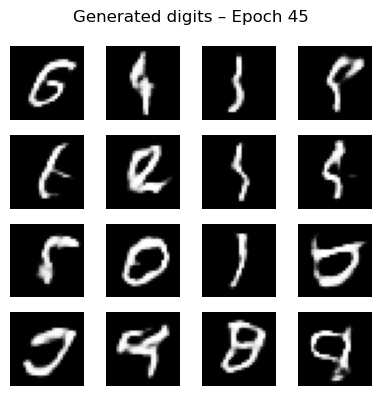

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-10
Epoch 050 | Gen Loss: 0.9060 | Disc Loss: 0.6303


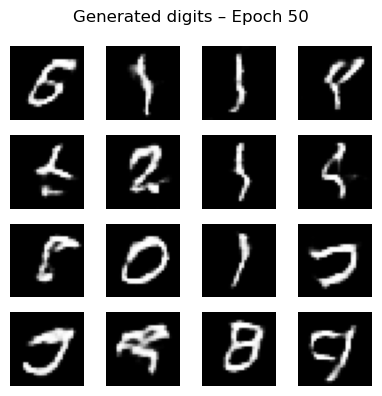

💾 Saved checkpoint: ./dcgan_mnist_checkpoints\ckpt-11
Training finished at: 2025-12-08 22:59:35.843116
Total training time: 0:26:37.369625


In [12]:
TRAIN_MODEL = True  # <-- set to False when you only want to analyze / generate

gen_losses = []
disc_losses = []

num_examples_to_generate = 16
fixed_seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

if TRAIN_MODEL:
    print(f"Starting (or resuming) training from epoch {start_epoch} to {EPOCHS}.")
    start_time = datetime.now()
    for epoch in range(start_epoch, EPOCHS + 1):
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in train_dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        mean_g = float(tf.reduce_mean(epoch_gen_loss))
        mean_d = float(tf.reduce_mean(epoch_disc_loss))
        gen_losses.append(mean_g)
        disc_losses.append(mean_d)

        # Update epoch counter in checkpoint
        epoch_counter.assign(epoch)

        if epoch % 5 == 0 or epoch == start_epoch or epoch == EPOCHS:
            print(f"Epoch {epoch:03d} | Gen Loss: {mean_g:.4f} | Disc Loss: {mean_d:.4f}")
            generate_and_save_images(generator, epoch, fixed_seed)

            # Save checkpoint
            ckpt_path = ckpt_manager.save()
            print(f"💾 Saved checkpoint: {ckpt_path}")

    end_time = datetime.now()
    print("Training finished at:", end_time)
    print("Total training time:", end_time - start_time)
else:
    # Only restore latest checkpoint (if any) and skip training
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print(f"Restored from {ckpt_manager.latest_checkpoint}. Skipping training (TRAIN_MODEL=False).")
    else:
        print("No checkpoint found and TRAIN_MODEL=False. Nothing to train or restore.")

---
Once the generator and discriminator are built, the next step is to train them together so the generator becomes better at creating realistic 
MNIST digits.
DCGAN training is unique because two models learn at the same time, each with opposite goals.

Step A — Generator creates fake images

 -  We start by sampling random noise of size 100. 
 - The generator turns this noise into a 28×28 fake digit.

Step B — Discriminator looks at real and fake images

 - The discriminator sees a batch of real MNIST images.
 - Then it sees a batch of fake images from the generator.
 - It outputs predictions for both (real vs fake).

Step C — Compute two losses

Generator loss:

 - Measures how well the generator fooled the discriminator.

 - If the discriminator thinks fake images look real → generator gets rewarded.

Discriminator loss:

 - Measures how well the discriminator correctly identifies real vs fake.

 - It gets rewarded for catching fake images and recognizing real ones.

Step D — Update both networks

 - We calculate gradients using tf.GradientTape.

The generator and discriminator each get updated using the Adam optimizer.

---

### 4.4 Plot training losses

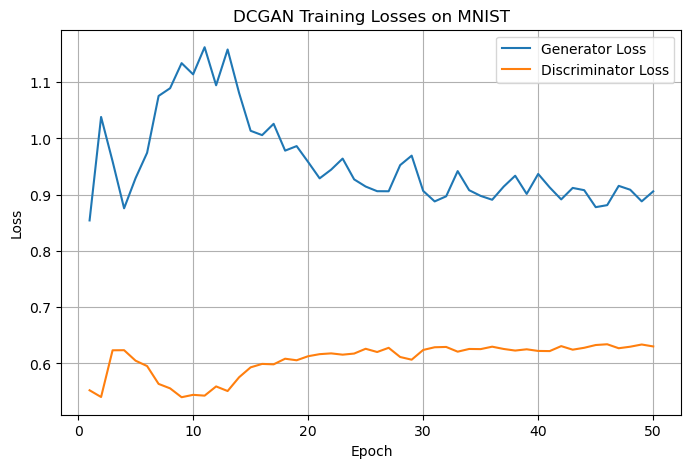

In [13]:
if gen_losses and disc_losses:
    epochs_range = range(start_epoch, start_epoch + len(gen_losses))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, gen_losses, label="Generator Loss")
    plt.plot(epochs_range, disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("DCGAN Training Losses on MNIST")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No recorded losses to plot (did you run training in this session?).")

## 5. Results & Analysis

In this section we:

- Visualize **real digits** vs **generated digits** side-by-side.  
- Explore **latent space interpolation** to see how digits morph.  
- Provide a short analysis template you can adapt for your report.


### 5.1 Compare real vs generated digits

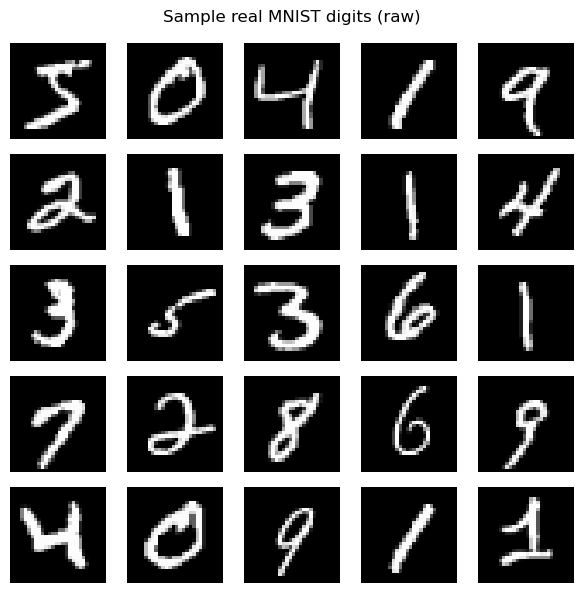

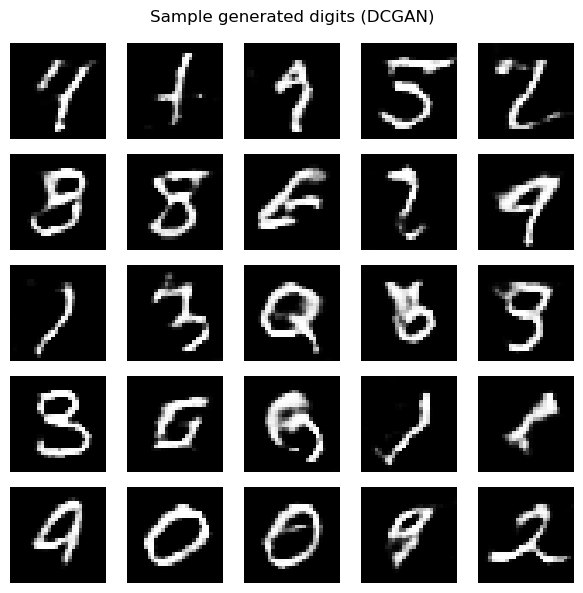

In [14]:
# Show some real digits (raw)
show_real_digits(X_train_raw, n=25, title="Sample real MNIST digits (raw)")

# Generate a grid of fake digits from the current generator
noise = tf.random.normal([25, NOISE_DIM])
generated = generator(noise, training=False)

plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = (generated[i, :, :, 0] + 1.0) / 2.0  # [-1,1] -> [0,1]
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Sample generated digits (DCGAN)")
plt.tight_layout()
plt.show()

### 5.2 Latent space interpolation

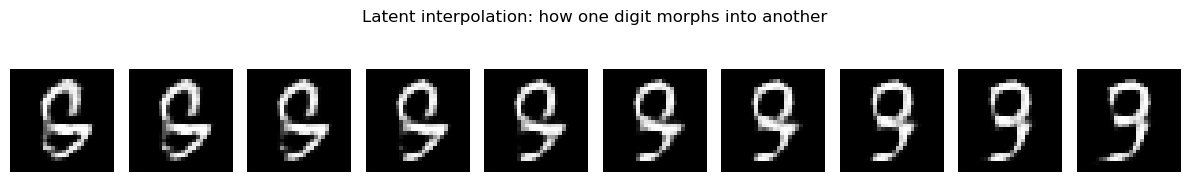

In [15]:
# Interpolate between two random points in the latent space
n_steps = 10
z1 = tf.random.normal([1, NOISE_DIM])
z2 = tf.random.normal([1, NOISE_DIM])

alphas = np.linspace(0, 1, n_steps)
z_interp = np.array([(1 - a) * z1 + a * z2 for a in alphas]).reshape(n_steps, NOISE_DIM)

imgs = generator(z_interp, training=False)

plt.figure(figsize=(12, 2))
for i in range(n_steps):
    plt.subplot(1, n_steps, i + 1)
    img = (imgs[i, :, :, 0] + 1.0) / 2.0
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Latent interpolation: how one digit morphs into another")
plt.tight_layout()
plt.show()

---

### 5.3 Analysis notes

1. Visual Quality

The generated digits become more recognizable as training progresses. By later epochs, many samples look sharp and realistic, showing clear digit structure. Some images may still appear slightly blurry or contain small artifacts, which is normal for basic DCGANs.

2. Diversity / Mode Collapse

A healthy GAN should generate all digits from 0–9. If you see only a few repeating digits (e.g., many 1s or 7s), this suggests mode collapse, meaning the generator has learned only a narrow part of the data distribution. Visual inspection of many samples helps detect this.

3. Training Dynamics

Good training shows:

 - Generator loss that is relatively stable—not exploding or dropping to zero.

 - Discriminator loss that stays within a reasonable range—not too low (overpowering) and not too high (too weak).
 Oscillations are normal, but extreme swings indicate instability.

4. Impact of Hyperparameters

Learning rate: Too high → unstable training; too low → slow progress.

Batch size: Larger batches stabilize gradients but require more memory.

Network depth/filters: More filters capture richer features but may overfit or destabilize training.

Stabilization tricks like label smoothing or adding small noise to inputs often improve training balance and image quality.

5. Optional Quantitative Evaluation

You can train a small MNIST classifier and use it to:

Predict labels for generated digits

Check if all digits appear

Measure classifier confidence
This helps objectively measure realism and diversity.

If you'd like, I can also generate a polished final conclusion section for the report.

---